# Exploring Dataset and Feature Engineering

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from datetime import datetime
# a nice way of filtering out deprecated warnings
import warnings
warnings.filterwarnings("ignore")


## Load Zone Information

In [2]:
dfzone = pd.read_csv("../raw_data/taxi+_zone_lookup.csv")

## Load NYC Taxi Data

In [3]:
df2019 = pd.read_feather('../raw_data/feather/df2019.feather')
df20192 = pd.read_feather('../raw_data/feather/df20192.feather')
df20193 = pd.read_feather('../raw_data/feather/df20193.feather')

The following code joins the data for each year

In [4]:
df_taxi = df2019.append(df20192, ignore_index = True)
df_taxi = df_taxi.append(df20193, ignore_index = True)

In [5]:
# reduce memory usage
del df2019
del df20192
del df20193

In [6]:
df_taxi.head()

,index,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,0,1,2019-03-01 00:24:41,2019-03-01 00:25:31,1,0.0,1,N,145,145,2,2.5,0.5,0.5,0.0,0.00,0.3,3.80,0.0
1,1,1,2019-03-01 00:25:27,2019-03-01 00:36:37,2,3.7,1,N,95,130,1,13.0,0.5,0.5,0.7,0.00,0.3,15.00,0.0
2,2,1,2019-03-01 00:05:21,2019-03-01 00:38:23,1,14.1,1,N,249,28,1,41.0,3.0,0.5,10.1,5.76,0.3,60.66,2.5
3,3,1,2019-03-01 00:48:55,2019-03-01 01:06:03,1,9.6,1,N,138,98,2,27.0,0.5,0.5,0.0,0.00,0.3,28.30,0.0
4,4,1,2019-03-01 00:11:42,2019-03-01 00:16:40,1,0.8,1,N,48,48,1,5.5,3.0,0.5,3.0,0.00,0.3,12.30,2.5


In [7]:
old_size= len(df_taxi)
old_size

22830945

### Convert datatypes to appropriate datatypes

In [8]:
df_taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22830945 entries, 0 to 22830944
Data columns (total 19 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   index                  int64  
 1   VendorID               int64  
 2   tpep_pickup_datetime   object 
 3   tpep_dropoff_datetime  object 
 4   passenger_count        int64  
 5   trip_distance          float64
 6   RatecodeID             int64  
 7   store_and_fwd_flag     object 
 8   PULocationID           int64  
 9   DOLocationID           int64  
 10  payment_type           int64  
 11  fare_amount            float64
 12  extra                  float64
 13  mta_tax                float64
 14  tip_amount             float64
 15  tolls_amount           float64
 16  improvement_surcharge  float64
 17  total_amount           float64
 18  congestion_surcharge   float64
dtypes: float64(9), int64(7), object(3)
memory usage: 3.2+ GB


First, reduce memory usage by changing to appropriate data type

In [9]:

#convert to int8
for i in ['VendorID', 'RatecodeID', 'passenger_count','payment_type','PULocationID', 
          'DOLocationID']:
    df_taxi[i]= df_taxi[i].astype('int16')

#convert to float32
for i in [ 'trip_distance','fare_amount', 
          'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 
          'improvement_surcharge', 'total_amount',
          'congestion_surcharge']:
    df_taxi[i]= df_taxi[i].astype('float32')
    


As seen in the .info(), the datetime columns have a data type of an object, convert it to a datatime date type in order to access more features.

In [10]:
df_taxi['tpep_pickup_datetime']= pd.to_datetime(df_taxi['tpep_pickup_datetime'])
print("converted pickup to ", type(df_taxi['tpep_pickup_datetime'][0]))
df_taxi['tpep_dropoff_datetime']= pd.to_datetime(df_taxi['tpep_dropoff_datetime'])
print("converted dropoff to ", type(df_taxi['tpep_dropoff_datetime'][0]))

converted pickup to  <class 'pandas._libs.tslibs.timestamps.Timestamp'>
converted dropoff to  <class 'pandas._libs.tslibs.timestamps.Timestamp'>


### Delete the irrelevant columns

In [11]:
df_taxi= df_taxi.drop(columns=['index', 'store_and_fwd_flag'])

In [12]:
df_taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22830945 entries, 0 to 22830944
Data columns (total 17 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int16         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        int16         
 4   trip_distance          float32       
 5   RatecodeID             int16         
 6   PULocationID           int16         
 7   DOLocationID           int16         
 8   payment_type           int16         
 9   fare_amount            float32       
 10  extra                  float32       
 11  mta_tax                float32       
 12  tip_amount             float32       
 13  tolls_amount           float32       
 14  improvement_surcharge  float32       
 15  total_amount           float32       
 16  congestion_surcharge   float32       
dtypes: datetime64[ns](2), float32(9), int16(6)
memory usage: 1.4 GB

Basic Intuitions based on columns:
    
    1. Date and Location feature will be relevant for the model that predicts taxi demand

### SUMMARY: Sorted Taxi Data Types for further cleaning

- Geographical data: PULocationID , DOLocationID
- Datatime data: tpep_pickup_datetime, tpep_dropoff_datetime
- Categorical Data: VendorID, RatecodeID, payment_type 
- Numerical Data: passenger_count, trip_distance, fare_amount, extra, mta_tax, tip_amount, tolls_amount, improvement_surchage, total_amount, congestion_surcharge

## Load Uber Data

In [13]:
# Load Feather
dffhv2019 = pd.read_feather("../raw_data/feather/fhvhv_tripdata_2019-03.feather")
dffhv20192 = pd.read_feather("../raw_data/feather/fhvhv_tripdata_2019-04.feather")
dffhv20193 = pd.read_feather("../raw_data/feather/fhvhv_tripdata_2019-05.feather")

#The following code joins the data for each year

df_fhv = dffhv2019.append(dffhv20192, ignore_index = True)
df_fhv = df_fhv.append(dffhv20193, ignore_index = True)

In [14]:
# reduce memory usage
del dffhv2019
del dffhv20192
del dffhv20193

In [15]:
print(df_fhv.shape)
df_fhv.head()

(67928519, 8)


,index,hvfhs_license_num,dispatching_base_num,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,SR_Flag
0,0,HV0004,B02800,2019-03-01 00:13:55,2019-03-01 00:28:51,36,80,1.0
1,1,HV0004,B02800,2019-03-01 00:23:58,2019-03-01 00:43:03,37,232,1.0
2,2,HV0005,B02510,2019-03-01 00:03:37,2019-03-01 00:15:09,25,62,NaN
3,3,HV0003,B02884,2019-03-01 00:29:46,2019-03-01 00:50:43,65,262,NaN
4,4,HV0003,B02884,2019-03-01 00:58:56,2019-03-01 01:20:47,140,196,NaN


In [16]:
old_size_fhv= len(df_fhv)

In [17]:
df_fhv.describe().round()

,index,PULocationID,DOLocationID,SR_Flag
count,67928519.0,67928519.0,67928519.0,12988111.0
mean,11339200.0,139.0,141.0,1.0
std,6567516.0,75.0,78.0,0.0
min,0.0,1.0,1.0,1.0
25%,5660710.0,74.0,75.0,1.0
50%,11321419.0,140.0,141.0,1.0
75%,16982129.0,211.0,216.0,1.0
max,23864597.0,265.0,265.0,1.0


### Check for Invalid Location ID

In [18]:
df_fhv.loc[df_fhv['PULocationID']<0]

,index,hvfhs_license_num,dispatching_base_num,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,SR_Flag


### Check Null Values

In [19]:
print(df_fhv["SR_Flag"])

0           1.0
1           1.0
2           NaN
3           NaN
4           NaN
           ... 
67928514    NaN
67928515    NaN
67928516    NaN
67928517    NaN
67928518    NaN
Name: SR_Flag, Length: 67928519, dtype: float64


### Delete the irrelevant columns

In [20]:
#check if there is missing entries
print(df_fhv.isnull().sum())

index                          0
hvfhs_license_num              0
dispatching_base_num        1043
pickup_datetime                0
dropoff_datetime               0
PULocationID                   0
DOLocationID                   0
SR_Flag                 54940408
dtype: int64


In [21]:
del df_fhv["index"]

In [22]:
del df_fhv["dispatching_base_num"]

In [23]:
del df_fhv["hvfhs_license_num"]

In [24]:
del df_fhv["SR_Flag"]

Since locationID is very relevant, the entries with missing locationID values should be removed. However, there is no need to remove any rows since there is no missing locationID data

### Convert datatypes to appropriate datatypes

In [25]:
df_fhv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67928519 entries, 0 to 67928518
Data columns (total 4 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   pickup_datetime   object
 1   dropoff_datetime  object
 2   PULocationID      int64 
 3   DOLocationID      int64 
dtypes: int64(2), object(2)
memory usage: 2.0+ GB


First, reduce memory usage for running 

In [26]:
#convert to Location IDs to int8
for i in ["PULocationID", "DOLocationID"]:
    df_fhv[i]= df_fhv[i].astype('int16')

As seen in the .info(), the datetime columns have a data type of an object, convert it to a datatime date type in order to access more features.

In [27]:
df_fhv['pickup_datetime']= pd.to_datetime(df_fhv['pickup_datetime'])
print("converted pickup to ", type(df_fhv['pickup_datetime'][0]))
df_fhv['dropoff_datetime']=  pd.to_datetime(df_fhv['dropoff_datetime'], errors = 'coerce')
print("converted dropoff to", type(df_fhv['dropoff_datetime'][0]))

converted pickup to  <class 'pandas._libs.tslibs.timestamps.Timestamp'>
converted dropoff to <class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [28]:
df_fhv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67928519 entries, 0 to 67928518
Data columns (total 4 columns):
 #   Column            Dtype         
---  ------            -----         
 0   pickup_datetime   datetime64[ns]
 1   dropoff_datetime  datetime64[ns]
 2   PULocationID      int16         
 3   DOLocationID      int16         
dtypes: datetime64[ns](2), int16(2)
memory usage: 1.3 GB


### SUMMARY: Sorted FHV Data Types for further cleaning
- Geographical data: PULocationID , DOLocationID
- Datatime data: pickup_datetime, dropoff_datetime

## Cleaning DateTime Data for Taxi and FHV datasets

### Remove invalid trips

Check for and remove invalid trips where there was a pickup after the dropoff. There cannot be a trip where there is 0 seconds trip since there is a minimum of 2.50 fee.

Taxi Dataset:

In [29]:
df_taxi.loc[df_taxi['tpep_pickup_datetime']>= df_taxi['tpep_dropoff_datetime']].count()

VendorID                 19358
tpep_pickup_datetime     19358
tpep_dropoff_datetime    19358
passenger_count          19358
trip_distance            19358
RatecodeID               19358
PULocationID             19358
DOLocationID             19358
payment_type             19358
fare_amount              19358
extra                    19358
mta_tax                  19358
tip_amount               19358
tolls_amount             19358
improvement_surcharge    19358
total_amount             19358
congestion_surcharge     19358
dtype: int64

In [30]:
df_taxi= df_taxi.loc[df_taxi['tpep_pickup_datetime']< df_taxi['tpep_dropoff_datetime']]

FHV Dataset:

In [31]:
df_fhv.loc[df_fhv['pickup_datetime']>= df_fhv['dropoff_datetime']].count()

pickup_datetime     80
dropoff_datetime    80
PULocationID        80
DOLocationID        80
dtype: int64

In [32]:
df_fhv= df_fhv.loc[df_fhv['pickup_datetime']< df_fhv['dropoff_datetime']]

## Adding DataTime related Features

### For Taxi Datasets

### Creating  total_trip_duration feature for Taxi and FHV
This is a feature that consists of the total trip duration in minutes


In [33]:
#Convert to seconds
df_taxi['total_trip_duration'] = (df_taxi['tpep_dropoff_datetime'] - df_taxi['tpep_pickup_datetime']).astype('timedelta64[s]')
#convert to minutes
df_taxi['total_trip_duration'] = df_taxi['total_trip_duration']/60


In [34]:
#Convert to seconds
df_fhv['total_trip_duration'] = (df_fhv['dropoff_datetime'] - df_fhv['pickup_datetime']).astype('timedelta64[s]')
#convert to minutes
df_fhv['total_trip_duration'] = df_fhv['total_trip_duration']/60


### Remove datetime outside of range for Taxi and FHV Data

In [35]:
date1= pd.Timestamp(datetime(2019, 3, 1))
date2= pd.Timestamp(datetime(2019, 5, 31))
# taxi
df_taxi= df_taxi.iloc[(df_taxi['tpep_pickup_datetime']).values> date1]
df_taxi= df_taxi.iloc[(df_taxi['tpep_pickup_datetime']).values< date2]
df_taxi= df_taxi.iloc[(df_taxi["tpep_dropoff_datetime"]).values> date1]
df_taxi= df_taxi.iloc[(df_taxi["tpep_dropoff_datetime"]).values< date2]
#fhv
df_fhv= df_fhv.iloc[(df_fhv['pickup_datetime']).values> date1]
df_fhv= df_fhv.iloc[(df_fhv['pickup_datetime']).values< date2]
df_fhv= df_fhv.iloc[(df_fhv["dropoff_datetime"]).values> date1]
df_fhv= df_fhv.iloc[(df_fhv["dropoff_datetime"]).values< date2]

### Create avespeed_ mileshr feature for Taxi Data
 This feature demonstrates speed of miles per hour (which is consistent with standard US speed measure). Lower average speed may be associated with traffic.

In [36]:
df_taxi['avespeed_mileshr']= df_taxi['trip_distance'] / (df_taxi['total_trip_duration']/60)

### Create time session feature for Taxi and FHV dataset
Bin hours into time sessions
According to https://learnersdictionary.com/qa/parts-of-the-day-early-morning-late-morning-etc

In [37]:
df_taxi['time session']=pd.cut(df_taxi['tpep_pickup_datetime'].dt.hour, [0,5,12,17,21,24],labels=['Night','Morning','Afternoon','Evening', 'Night'],include_lowest=True, ordered=False)
df_fhv['time session']=pd.cut(df_fhv['pickup_datetime'].dt.hour, [0,5,12,17,21,24],labels=['Night','Morning','Afternoon','Evening', 'Night'],include_lowest=True, ordered=False)

In [38]:
df_fhv['time session']

0           Night
1           Night
2           Night
3           Night
4           Night
            ...  
67171187    Night
67171188    Night
67171189    Night
67171192    Night
67171193    Night
Name: time session, Length: 67160702, dtype: category
Categories (4, object): ['Afternoon', 'Evening', 'Morning', 'Night']

### Create date column

In [39]:
df_taxi['date']= df_taxi['tpep_pickup_datetime'].dt.date

In [40]:
df_fhv['date']= df_fhv['pickup_datetime'].dt.date

### Create hour column

In [41]:
df_taxi['hour']= df_taxi['tpep_pickup_datetime'].dt.hour

In [42]:
df_fhv['hour']= df_fhv['pickup_datetime'].dt.hour

## Inspecting Numerical Data 

We won't be looking at the Uber Dataset in terms of data cleaning numerical data since there is no numerical data available.

In [43]:
numerical_data= ['passenger_count', 'trip_distance', 'fare_amount',
                 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
                 'improvement_surcharge', 'total_amount', 
                 'congestion_surcharge', 'total_trip_duration']
df_taxi[numerical_data].describe().round(1)


,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,total_trip_duration
count,22549585.0,22549585.0,22549585.0,22549585.0,22549585.0,22549585.0,22549585.0,22549585.0,22549585.0,22549585.0,22549585.0
mean,1.6,2.8,12.6,1.1,0.4,2.2,0.4,0.3,18.2,2.3,17.9
std,1.2,3.7,218.5,1.3,0.2,29.8,1.7,0.0,245.9,0.7,70.7
min,0.0,0.0,-450.1,-57.5,-0.5,-89.9,-25.0,-0.3,-450.9,-2.5,0.0
25%,1.0,1.0,6.5,0.0,0.5,0.0,0.0,0.3,11.3,2.5,6.7
50%,1.0,1.6,9.5,0.5,0.5,2.0,0.0,0.3,14.8,2.5,11.2
75%,2.0,3.1,14.5,2.5,0.5,3.0,0.0,0.3,20.8,2.5,18.5
max,9.0,830.9,943274.8,24.7,60.8,141492.0,921.1,1.0,1084772.1,4.5,27454.8


Observations based on testing df description:

- Negative fare amount, extra, tip_amount, toll_amounts, mta_tax and total amount exists. This could be due to refunds and can be considered to be deleted from data. Also, fare amount has to be at least 2.50 USD (https://www1.nyc.gov/site/tlc/passengers/taxi-fare.page)
- Outlier->The maximum payments and distance seem to be excessive and large.
- Outlier-> The minimum trip distances should be greater than 0
- Median and mean is not always equal for certain attributes. This indicates that we are dealing with skewed dataset

### Remove Invalid Relevant Payments 

This is a relevant process since we are considering to add tip_amount as a feature

In [44]:
#This removes the negative payments, free rides, no passengers and 0 distance rides
df_taxi= df_taxi.loc[(df_taxi['fare_amount']>=2.5) &
                   (df_taxi['trip_distance']> 0) &
                    (df_taxi['tip_amount']>=0) &
                    (df_taxi['passenger_count']>0)&
                    (df_taxi['congestion_surcharge']> 0) & 
                    (df_taxi['total_trip_duration']> 1) &
                     (df_taxi['trip_distance']< 613) &
                    (df_taxi['total_trip_duration']< 12*60), :]

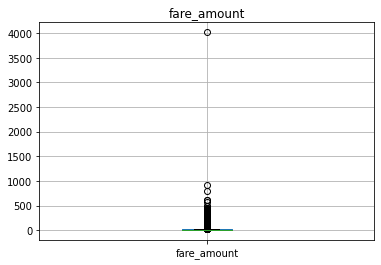

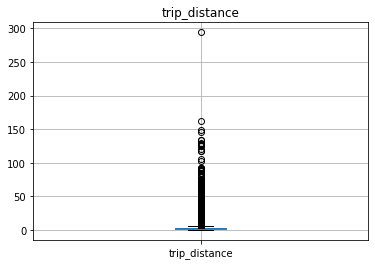

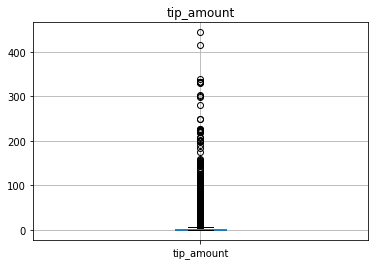

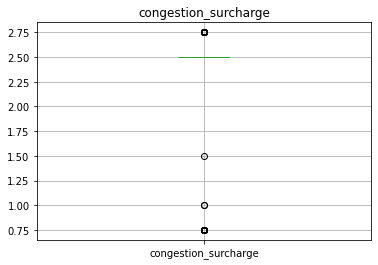

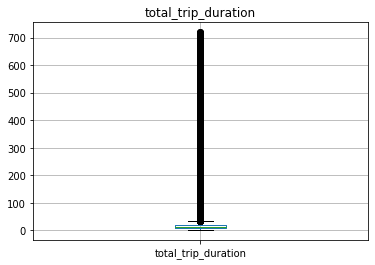

In [45]:
for i in ['fare_amount', 'trip_distance','tip_amount',
    'congestion_surcharge','total_trip_duration']:
    df_taxi.boxplot(column= i)
    plt.title(i)
    plt.show()

In [46]:
#remove isolated outliers and cut tip amount at 200 to remove extremely high tip amounts
df_taxi= df_taxi.loc[(df_taxi['fare_amount']< 1000) & 
                   (df_taxi['trip_distance']< 200) & 
                    (df_taxi['tip_amount']<200), :]

https://www.netstate.com/states/geography/ny_geography.htm


In [47]:
df_fhv= df_fhv.loc[(df_fhv['total_trip_duration']> 1) &
                    (df_fhv['total_trip_duration']< 12*60), :]

### Create Passenger Count column for FHV Dataset
We are assuming that the passenger count is under a similar distribution as the taxi dataset. This is further backed up by the report indicating that uber passenger count mean is 1.75-2 matching with the summary we have indicating that passenger count mean is 1.6. (https://pantonium.com/some-uber-statistics/) 
However, in order to determine whether we are to use the median (1) or mean (2), we should calculate the percentage of taxi dataset where there is 1 passenger

Median and mean is not always equal for certain attributes. This indicates that we are dealing with skewed dataset. 

In [48]:
len(df_taxi[df_taxi['passenger_count']==   1])/df_taxi.shape[0]

0.7118616014197262

Since around 70% of the data is of one pessenger and since 1 is a minimum, the data is indicated to be right skewed. Hence , we will use the median

In [49]:
df_fhv['passenger_count']=1

## Cleaning Categorical Data

In [50]:
categorical_data= ['VendorID', 'RatecodeID', 'payment_type']

In [51]:
#Check if the values align with the values given with the 
# data details
for i in categorical_data:
    print(i+ ':',df_taxi[i].value_counts().index)

VendorID: Int64Index([2, 1, 4], dtype='int64')
RatecodeID: Int64Index([1, 2, 5, 4, 99, 3, 6], dtype='int64')
payment_type: Int64Index([1, 2, 3, 4], dtype='int64')


Since VendorID is an irrelevant feature, we wouldn't need to remove the invalid ID of 4 since the rest of the features of the entries may be valid.
For RatecodeID, there is an invalid RatecodeID of 99. Since we want only want standard rides to predict for typical demand, this should be removed along with the other payment types that are not standard.
Before we remove these values, we should inspect the distribution of categorial data

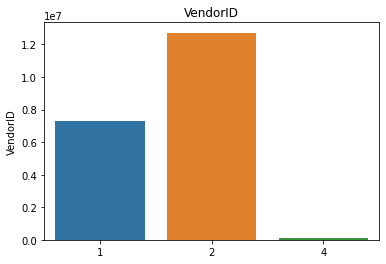

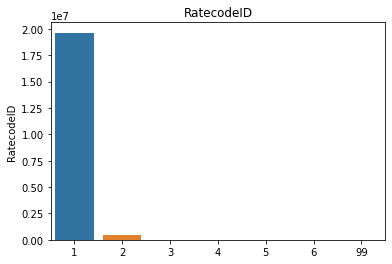

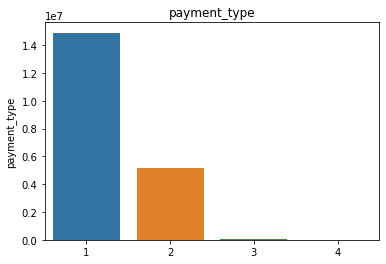

In [52]:
for i in categorical_data:
    sns.barplot(df_taxi[i].value_counts().index, df_taxi[i].value_counts())
    plt.title(i)
    plt.show()

The plot tells us that majority of the data lies in the standard rate with payment mostly being through cash or card

In [53]:
df_taxi= df_taxi.loc[df_taxi["RatecodeID"]==1]
df_taxi=  df_taxi.loc[df_taxi["payment_type"]<=2]

## Cleaning Location Zone Dataset

In [54]:
dfzone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   LocationID    265 non-null    int64 
 1   Borough       265 non-null    object
 2   Zone          264 non-null    object
 3   service_zone  263 non-null    object
dtypes: int64(1), object(3)
memory usage: 8.4+ KB


In [55]:
dfzone.describe()

,LocationID
count,265.000000
mean,133.000000
std,76.643112
min,1.000000
25%,67.000000
50%,133.000000
75%,199.000000
max,265.000000


### Remove the duplicates

In [56]:
print("There is duplicates. This statement is:", dfzone.duplicated(subset=['Borough', 'Zone', 'service_zone']).any())
dfzone[dfzone[['Borough', 'Zone', 'service_zone']].duplicated(keep=False) == True]

There is duplicates. This statement is: True


,LocationID,Borough,Zone,service_zone
55,56,Queens,Corona,Boro Zone
56,57,Queens,Corona,Boro Zone
102,103,Manhattan,Governor's Island/Ellis Island/Liberty Island,Yellow Zone
103,104,Manhattan,Governor's Island/Ellis Island/Liberty Island,Yellow Zone
104,105,Manhattan,Governor's Island/Ellis Island/Liberty Island,Yellow Zone


Look into the duplicates further before considering to remove the rows

In [57]:
print("For Taxi datasets:")
#Checking Location ID 56 and 57
print("The number of trips with PUlocation ID of 56 is", len(df_taxi.loc[df_taxi['PULocationID']== 56]))
print("The number of trips with PUlocation ID of 57 is", len(df_taxi.loc[df_taxi['PULocationID']== 57]))
#Checking location ID 103,104,105
print("The number of trips with PUlocation ID of 103 is", len(df_taxi.loc[df_taxi['PULocationID']== 103]))
print("The number of trips with PUlocation ID of 104 is", len(df_taxi.loc[df_taxi['PULocationID']== 104]))
print("The number of trips with PUlocation ID of 105 is", len(df_taxi.loc[df_taxi['PULocationID']== 105]))

print("For FHV datasets:")
#Checking Location ID 56 and 57
print("The number of trips with PUlocation ID of 56 is", len(df_fhv.loc[df_fhv['PULocationID']== 56]))
print("The number of trips with PUlocation ID of 57 is", len(df_fhv.loc[df_fhv['PULocationID']== 57]))
#Checking location ID 103,104,105
print("The number of trips with PUlocation ID of 103 is", len(df_fhv.loc[df_fhv['PULocationID']== 103]))
print("The number of trips with PUlocation ID of 104 is", len(df_fhv.loc[df_fhv['PULocationID']== 104]))
print("The number of trips with PUlocation ID of 105 is", len(df_fhv.loc[df_fhv['PULocationID']== 105]))

For Taxi datasets:
The number of trips with PUlocation ID of 56 is 41
The number of trips with PUlocation ID of 57 is 4
The number of trips with PUlocation ID of 103 is 0
The number of trips with PUlocation ID of 104 is 0
The number of trips with PUlocation ID of 105 is 29
For FHV datasets:
The number of trips with PUlocation ID of 56 is 173954
The number of trips with PUlocation ID of 57 is 13040
The number of trips with PUlocation ID of 103 is 0
The number of trips with PUlocation ID of 104 is 0
The number of trips with PUlocation ID of 105 is 15


Since there is only relatively much smaller proportion of trips in area 57 compared to 56, it is safe to assume that there may have been a mistake and the same location was matched to a locationID twice. Hence, all trips from locationid 57 will be marked as 56. As for the the last 3 locationsIDs, there is no need to combine data since Locations IDs 103 and 104 are not present in the taxi and fhv dataset.

In [58]:
df_taxi.loc[df_taxi['PULocationID']== 57,'PULocationID' ] = 56
df_taxi.loc[df_taxi['DOLocationID']== 57, 'DOLocationID'] = 56
df_fhv.loc[df_fhv['PULocationID']== 57, 'PULocationID'] = 56
df_fhv.loc[df_fhv['DOLocationID']== 57, 'DOLocationID'] = 56

### Delete Invalid Zones

Remove the last two invalid entries and any other similar entries

In [59]:
dfzone.loc[dfzone["Borough"]=='Unknown']

,LocationID,Borough,Zone,service_zone
263,264,Unknown,NV,NaN
264,265,Unknown,NaN,NaN


In [60]:
df_taxi= df_taxi.loc[df_taxi['PULocationID']!= 264]
df_fhv= df_fhv.loc[df_fhv['PULocationID']!= 264]
df_taxi= df_taxi.loc[df_taxi['PULocationID']!= 265] 
df_fhv= df_fhv.loc[df_fhv['PULocationID']!= 265] 

## Loading Weather Data

In [61]:
dfweather = pd.read_csv("../data/large/weather_data_3-5_2019.csv")
dfweather.reset_index().to_feather('../data/large/weather_data_3-5_2019.feather')
dfweather = pd.read_feather('../data/large/weather_data_3-5_2019.feather')

In [62]:
dfweather.head()

,index,station,valid,lon,lat,tmpf,tmpc,dwpf,dwpc,relh,feel,drct,sknt,sped,alti,mslp,p01m
0,0,NYC,2019-03-01 00:51,-73.9693,40.779,30.0,-1.11,10.9,-11.72,44.37,NaN,NaN,NaN,NaN,30.28,1024.8,0.00
1,1,NYC,2019-03-01 01:51,-73.9693,40.779,30.0,-1.11,14.0,-10.00,50.88,NaN,NaN,NaN,NaN,30.30,1025.5,0.00
2,2,NYC,2019-03-01 02:51,-73.9693,40.779,30.0,-1.11,15.1,-9.39,53.38,NaN,NaN,NaN,NaN,30.33,1026.2,0.00
3,3,NYC,2019-03-01 03:51,-73.9693,40.779,30.0,-1.11,16.0,-8.89,55.52,NaN,NaN,NaN,NaN,30.30,1025.4,0.00
4,4,NYC,2019-03-01 04:48,-73.9693,40.779,28.4,-2.00,19.4,-7.00,68.61,NaN,NaN,NaN,NaN,30.34,NaN,T


In [63]:
dfweather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2867 entries, 0 to 2866
Data columns (total 17 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   index    2867 non-null   int64  
 1   station  2867 non-null   object 
 2   valid    2867 non-null   object 
 3   lon      2867 non-null   float64
 4   lat      2867 non-null   float64
 5   tmpf     2774 non-null   float64
 6   tmpc     2774 non-null   float64
 7   dwpf     2774 non-null   float64
 8   dwpc     2774 non-null   float64
 9   relh     2774 non-null   float64
 10  feel     2212 non-null   float64
 11  drct     1513 non-null   float64
 12  sknt     2281 non-null   float64
 13  sped     2281 non-null   float64
 14  alti     2860 non-null   float64
 15  mslp     2096 non-null   float64
 16  p01m     2867 non-null   object 
dtypes: float64(13), int64(1), object(3)
memory usage: 380.9+ KB


The following code drops the unnecessary date, ename the columns to be more readable and change the data to the appropriate datatype:

In [64]:
dfweather= dfweather.rename(columns={"valid":"datetime","lon": "longitude", "lat": "latitude", "tmpf": "tempF", "relh": "relhumidity", "p01m" : "precipitation" }, errors="raise")

In [65]:
dfweather= dfweather.drop(columns=['index','station','tmpc', 'dwpf','dwpc', 'feel', 'drct', 'sknt', 'sped', 'alti', 'mslp'])

In [66]:
# Change dates to  datetime type
dfweather['datetime']= dfweather['datetime'].apply(lambda ogdate: datetime.strptime(str(ogdate), '%Y-%m-%d %H:%M'))

Check for null values:

In [67]:
#check if there is missing entries
print(dfweather.isnull().sum())

datetime          0
longitude         0
latitude          0
tempF            93
relhumidity      93
precipitation     0
dtype: int64


In [68]:
dfweather= dfweather.loc[dfweather['relhumidity'].notna()]
dfweater= dfweather.loc[dfweather['precipitation'].notna()]

In [69]:
dfweather.describe().round(1)

,longitude,latitude,tempF,relhumidity
count,2774.0,2774.0,2774.0,2774.0
mean,-74.0,40.8,51.9,66.5
std,0.0,0.0,11.9,23.5
min,-74.0,40.8,18.0,13.0
25%,-74.0,40.8,44.1,46.8
50%,-74.0,40.8,52.0,69.4
75%,-74.0,40.8,60.1,89.5
max,-74.0,40.8,86.0,100.0


The longitude and latitude seems to be unnecessary information since all of are the same (-74longitude and 41 latitude). Hence it can be deleted

In [70]:
dfweather= dfweather.drop(columns =['longitude', 'latitude'])

In [71]:
# https://www.thoughtco.com/what-is-trace-of-precipitation-3444238
dfweather.loc[dfweather['precipitation']=="T", 'precipitation']= 0.005 #changed to 0.005 because meteoroligst counts min 0.01
dfweather["precipitation"] = dfweather["precipitation"].apply(pd.to_numeric)
dfweather.loc[dfweather["precipitation"]>0.00]

,datetime,tempF,relhumidity,precipitation
4,2019-03-01 04:48:00,28.4,68.61,0.005
5,2019-03-01 04:51:00,28.9,68.67,0.005
6,2019-03-01 04:56:00,28.0,77.57,0.005
7,2019-03-01 05:05:00,27.0,84.66,0.510
8,2019-03-01 05:13:00,27.0,84.66,1.020
...,...,...,...,...
2859,2019-05-30 22:16:00,63.0,96.88,0.005
2860,2019-05-30 22:24:00,63.0,96.88,0.005
2861,2019-05-30 22:31:00,63.0,96.88,0.005
2862,2019-05-30 22:40:00,63.0,96.88,0.005


## Joining Datasets

In [72]:
df_taxi.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'PULocationID',
       'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount',
       'congestion_surcharge', 'total_trip_duration', 'avespeed_mileshr',
       'time session', 'date', 'hour'],
      dtype='object')

In [73]:
df_taxi= df_taxi.rename(columns={"tpep_pickup_datetime":"pickup_datetime", "tpep_dropoff_datetime": "dropoff_datetime"}, errors="raise")

In [74]:
print("Taxi dataset has", df_taxi.isnull().sum().sum(),"missing values.")
print("FHV dataset has", df_fhv.isnull().sum().sum(),"missing values.")

Taxi dataset has 0 missing values.
FHV dataset has 0 missing values.


In [75]:
print("Taxi Dataset had originally", old_size, ". Now, there is only", len(df_taxi), "elements in the dataset.")
print("FHV Dataset had originally", old_size_fhv, ". Now, there is only", len(df_fhv), "elements in the dataset.")

Taxi Dataset had originally 22830945 . Now, there is only 19467504 elements in the dataset.
FHV Dataset had originally 67928519 . Now, there is only 67134542 elements in the dataset.


In [76]:
df_taxi['type']= "taxi"
df_fhv['type']= "fhv"
jointdf= df_taxi.append(df_fhv, ignore_index = True)

In [ ]:
jointdf.reset_index().to_feather("../preprocessed_data/feather/joint_tripdata_2019.feather")

In [ ]:
joint

In [ ]:
dfweather.to_csv('../preprocessed_data/dfweather', index=False)